In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [4]:
#len(kdoys)
#len(kdates[::2])

#np.arange(0, math.pi*2, 0.05)

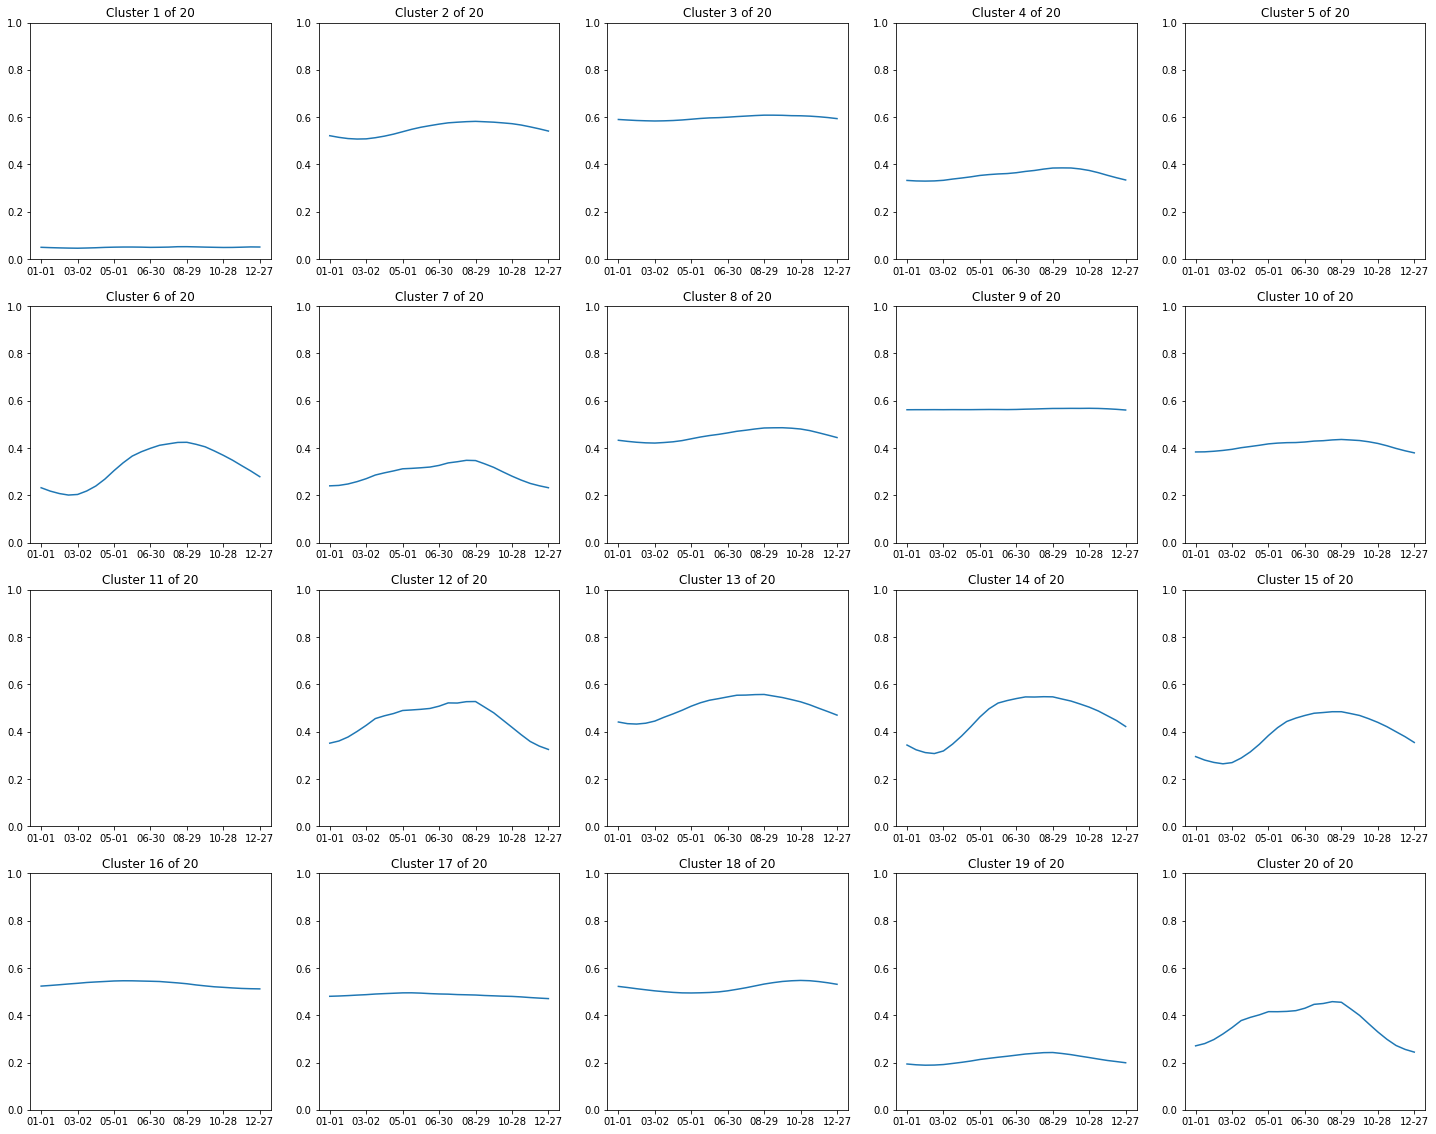

In [5]:
# Read k=20 final centroids
k20_cent = pd.read_csv('k_20/seeds.out.costa_rica_panama_biweekly_smooth.2017-2020.20.final', delimiter="\t", header=None)
#k20_cent = np.loadtxt('k_20/seeds.out.costa_rica_panama_biweekly_smooth.2017-2020.20.final', delimiter='\t')
clust=20
ncols=5
nrows=int(clust/5)
kdoys = np.arange(1,365,15) 
kdates=["01-01", "01-16", "01-31", "02-15", "03-02", "03-17", "04-01", "04-16", "05-01", "05-16", "05-31", "06-15", "06-30", "07-15", "07-30", "08-14", "08-29", "09-13", "09-28", "10-13", "10-28", "11-12", "11-27", "12-12", "12-27"]

fig, ax = plt.subplots(nrows, ncols, figsize=(25,20))

for k in range(clust):
    r=int(k/ncols)
    c=int(k%ncols)
    ax[r,c].plot(kdoys, k20_cent.iloc[k,:])
    ax[r,c].set_xticks(np.arange(1,365,60))
    ax[r,c].set_xticklabels(kdates[::4])
    ax[r,c].set_ylim([0,1])
    #ax[r,c].set_xticks(np.arange(0,25,6))
    ax[r,c].set_title('Cluster %d of %d'%(k+1, clust))

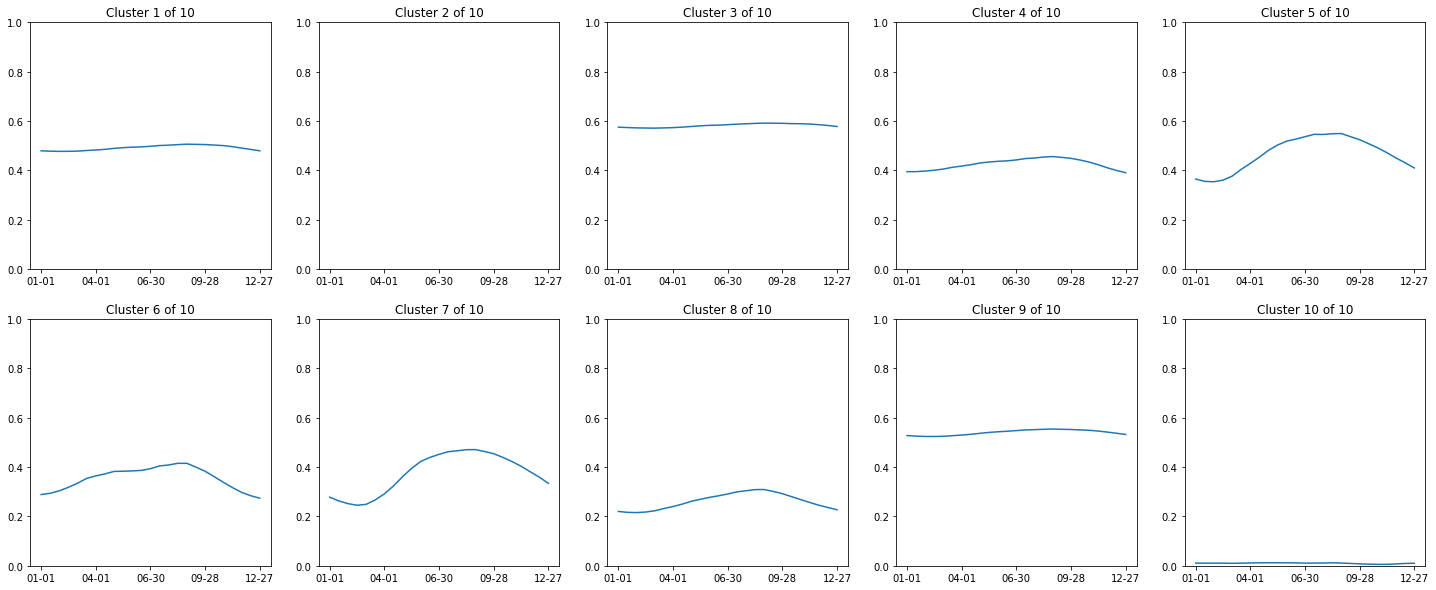

In [6]:
# Read k=10 final centroids
k10_cent = pd.read_csv('k_10/seeds.out.costa_rica_panama_biweekly_smooth.2017-2020.10.final', delimiter="\t", header=None)
#k10_cent = np.loadtxt('k_10/seeds.out.costa_rica_panama_biweekly_smooth.2017-2020.20.final', delimiter='\t')
clust=10
ncols=5
nrows=int(clust/5)
kdates=["01-01", "01-16", "01-31", "02-15", "03-02", "03-17", "04-01", "04-16", "05-01", "05-16", "05-31", "06-15", "06-30", "07-15", "07-30", "08-14", "08-29", "09-13", "09-28", "10-13", "10-28", "11-12", "11-27", "12-12", "12-27"]
fig, ax = plt.subplots(nrows, ncols, figsize=(25,10))

for k in range(clust):
    r=int(k/ncols)
    c=int(k%ncols)
    ax[r,c].plot(kdates, k10_cent.iloc[k,:])

    ax[r,c].set_ylim([0,1])
    ax[r,c].set_xticks(np.arange(0,25,6))
    ax[r,c].set_title('Cluster %d of %d'%(k+1, clust))

In [7]:
# Compute transition matrix
year1=2019
year2=2020
case='costa_rica'
nclust=10

chunksize=100000

transition_matrix=np.zeros((nclust,nclust)) #, dtype=np.float32)
ccount=np.zeros((nclust), int) #, dtype=np.uint32)
counter=0
#print(transition_matrix)
f1name='k_%d/clusters.%s.%d'%(nclust,case,year1)
f2name='k_%d/clusters.%s.%d'%(nclust,case,year2)

print("SPLIT: Working on files: %s and %s\n"%(f1name, f2name))
for (chunk1, chunk2) in zip(pd.read_csv(f1name, delimiter=" ", header=None, names=['cy1'], dtype=int, chunksize=chunksize), pd.read_csv(f2name, delimiter=" ", header=None, names=['cy2'], dtype=int, chunksize=chunksize)):
	# update the transition matrix
	for (c1, c2) in zip(chunk1['cy1'].astype(int), chunk2['cy2'].astype(int)):
		transition_matrix[int(c1)-1, int(c2)-1] = transition_matrix[int(c1)-1, int(c2)-1] + 1
		ccount[int(c1)-1]=ccount[int(c1)-1]+1
	counter =counter + len(chunk1)
#	break

	
print('Total points: %d\n'%(counter))
#print(transition_matrix)
for i in range(nclust):
	for j in range(nclust):
		transition_matrix[i,j] = (transition_matrix[i,j] * 100.0)/ccount[i]
print(transition_matrix)
tname='transition_%s_%d-%d.txt'%(case,year1,year2)
tfname='transition_%s_%d-%d.png'%(case,year1,year2)
### save the transition matrix
np.savetxt(tname, transition_matrix, delimiter=',')

transition_matrix=np.loadtxt(tname, dtype=float, delimiter=',')
# plot the transition matrix 
plt.figure(figsize=(20,15))
sns_plot = sns.heatmap(transition_matrix, linewidth=0.5, annot=True, annot_kws={"size": 20}, xticklabels=range(1,nclust+1), yticklabels=range(1,nclust+1))
plt.savefig(tfname, dpi=300)

SPLIT: Working on files: k_10/clusters.costa_rica.2019 and k_10/clusters.costa_rica.2020



KeyboardInterrupt: 

In [8]:
# create dates for the S2 time series 
dates=pd.date_range(start='2017-01-01', periods=25, freq='15D')
dates=dates.union(pd.date_range(start='2018-01-01', periods=25, freq='15D'))
dates=dates.union(pd.date_range(start='2019-01-01', periods=25, freq='15D'))
dates=dates.union(pd.date_range(start='2020-01-01', periods=25, freq='15D'))
phen_years=pd.DatetimeIndex(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2020-12-31'])


In [9]:
## Plot VPD, TP,T2M, SWVL time series
# Vapor Pressure Deficit
vpd_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2020+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/vpd_costa_rica_panama_k10_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        vpd_stats = vpd_stats.append(ustat, ignore_index=True)

# make date the index variable
vpd_stats.set_index('date', inplace=True)

# Total Precipitation
tp_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2020+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/tp_costa_rica_panama_k10_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        tp_stats = tp_stats.append(ustat, ignore_index=True)

# make date the index variable
tp_stats.set_index('date', inplace=True)

# 2m air temperature
t2m_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2020+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/t2m_costa_rica_panama_k10_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        t2m_stats = t2m_stats.append(ustat, ignore_index=True)

# make date the index variable
t2m_stats.set_index('date', inplace=True)

# Volumetric Soil Water Content
swvl_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2020+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/swvl_costa_rica_panama_k10_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        swvl_stats = swvl_stats.append(ustat, ignore_index=True)

# make date the index variable
swvl_stats.set_index('date', inplace=True)

In [10]:
# read cluster areas -- these were calculated using r.report and added to file k10.area
# r.report -ni costa_rica_panama_biweekly_smooth.2017-2020.2017.10 units=h
# r.report -ni costa_rica_panama_biweekly_smooth.2017-2020.2018.10 units=h
# r.report -ni costa_rica_panama_biweekly_smooth.2017-2020.2019.10 units=h
# r.report -ni costa_rica_panama_biweekly_smooth.2017-2020.2020.10 units=h
k10_area = pd.read_csv("k_10/k10.area", delimiter=" ")

# create a date time series, with middle of the year, for plotting purposed
adates = pd.DatetimeIndex(['2017-07-01', '2018-07-01', '2019-07-01', '2020-07-01'])
# Read polarMetrics 
k10_polar = pd.read_csv('k_10/k10.polarmetrics', delimiter=" ")

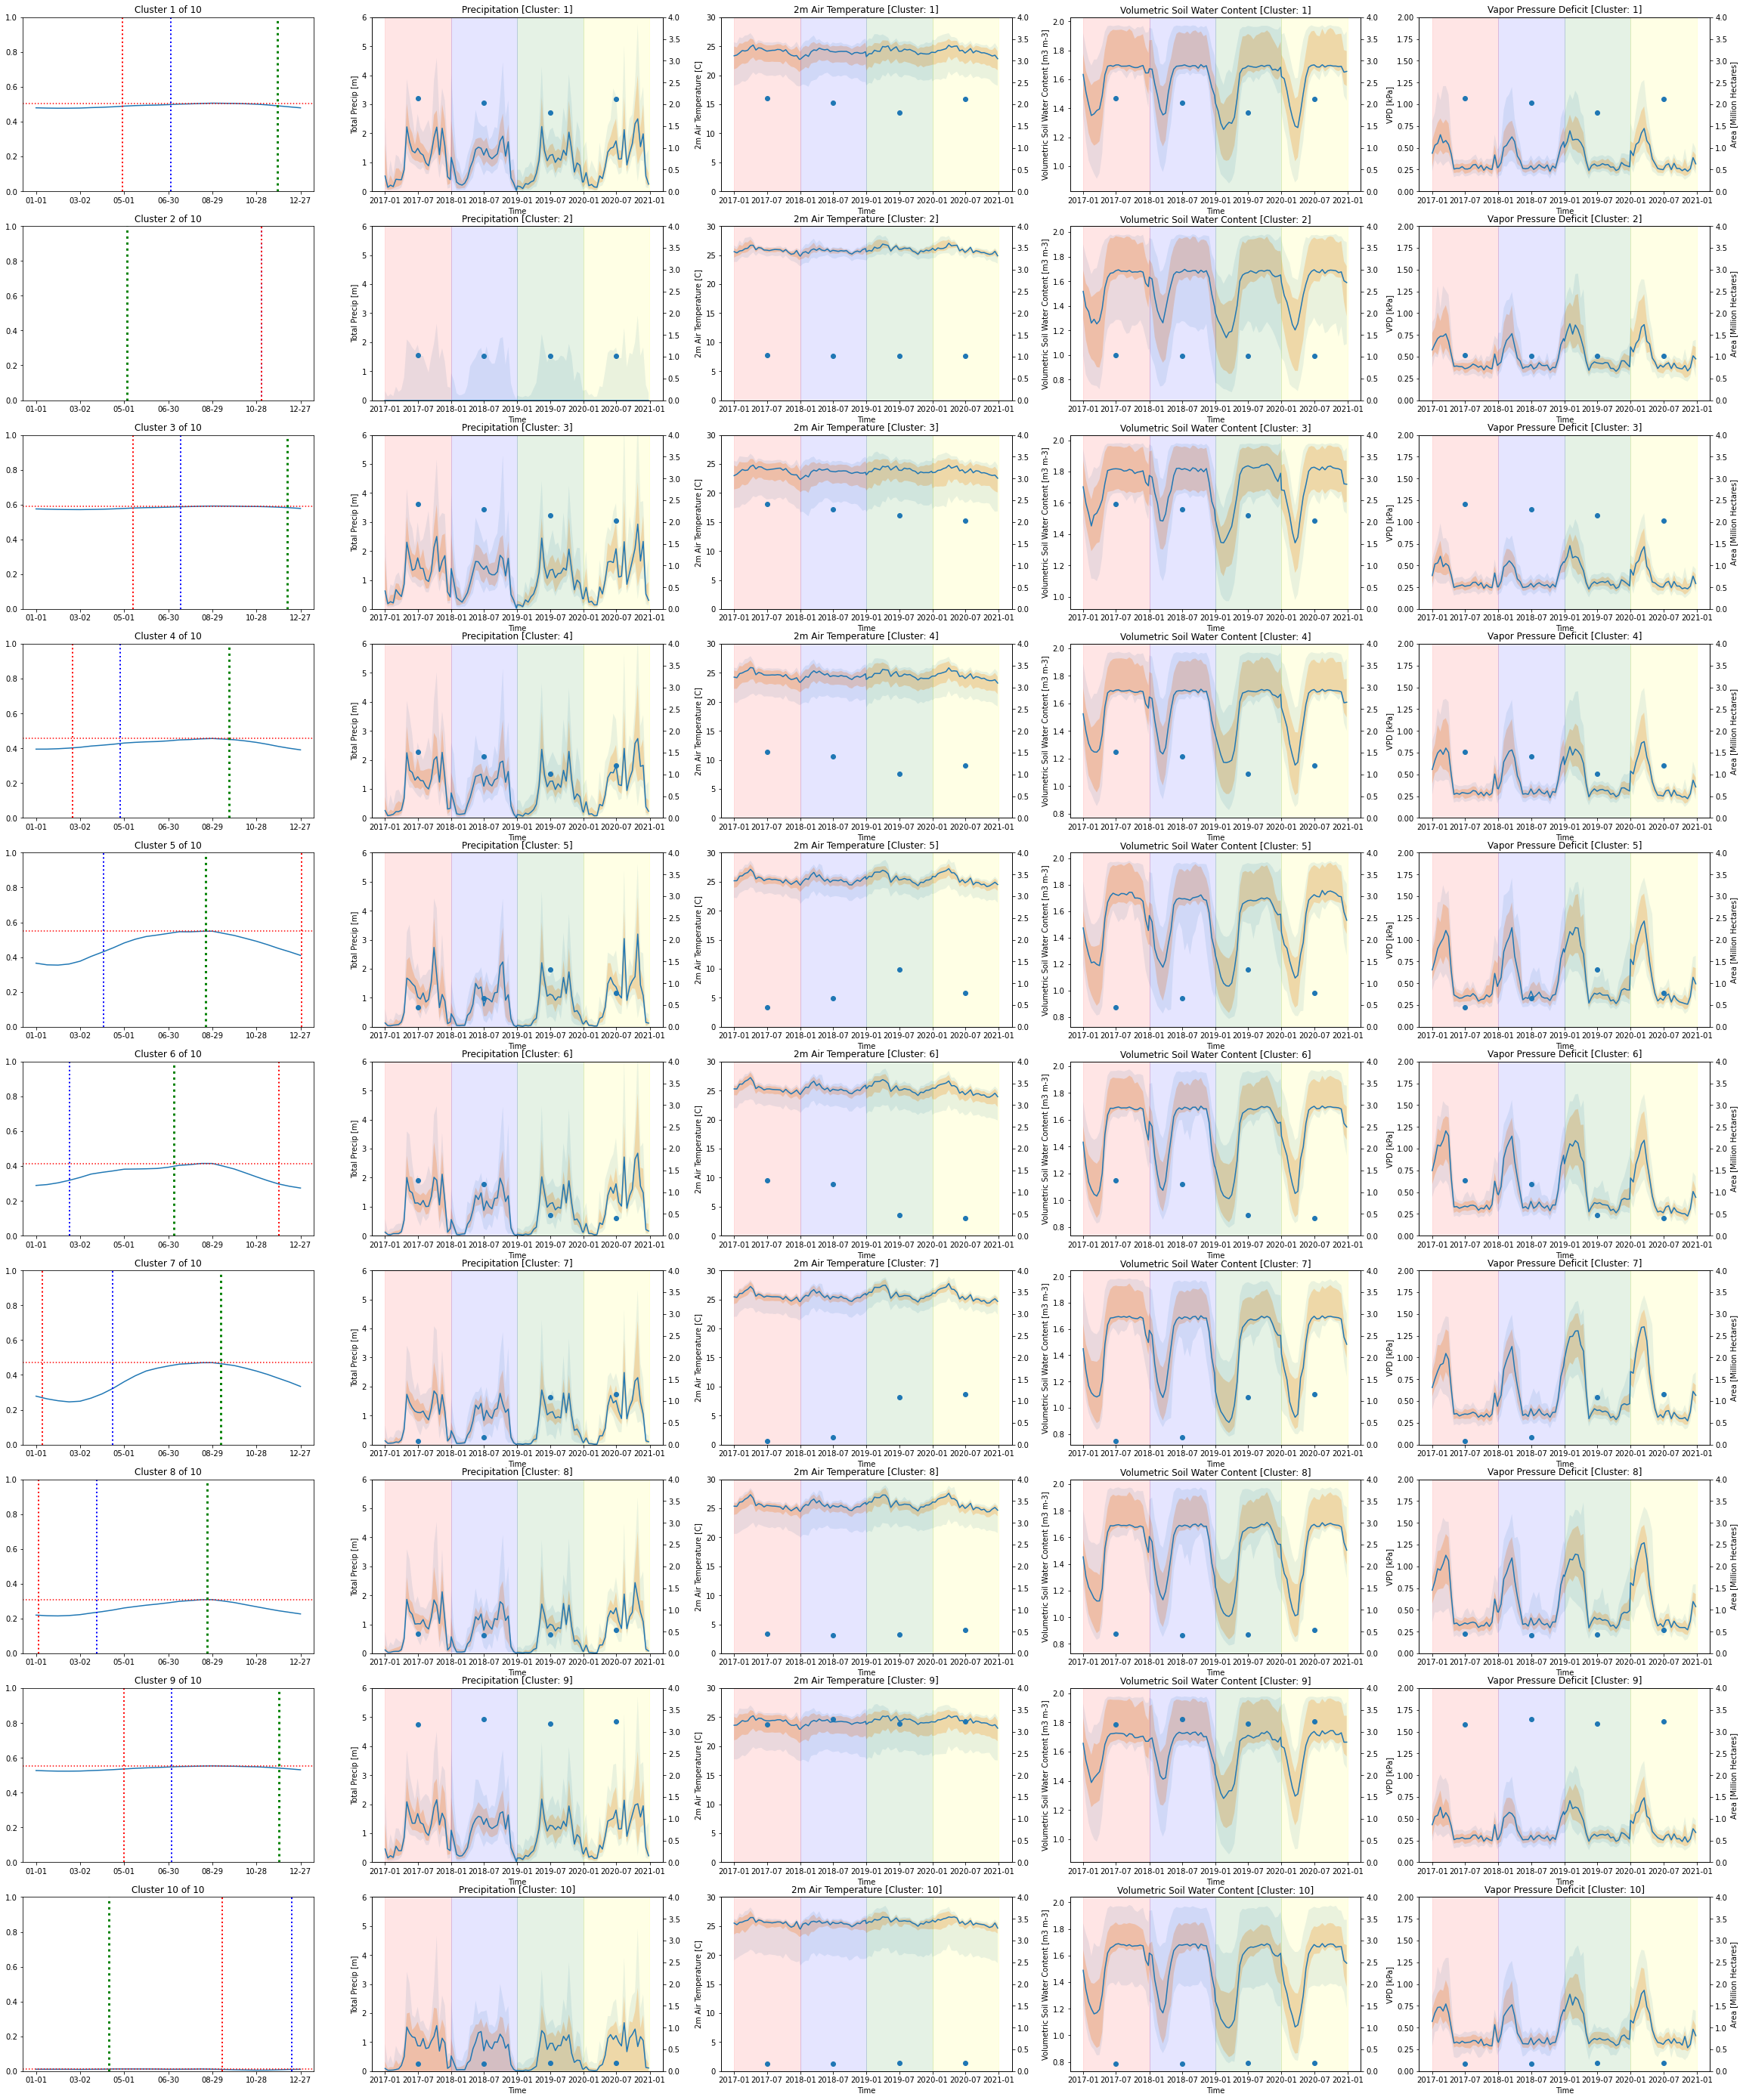

In [62]:
# Plot for each cluster
nclust=10

fig, axs = plt.subplots(10, 5, figsize=(40,50))
for k in range(nclust):
    # Plot Cluster centroid
    axs[k,0].plot(kdoys, k10_cent.iloc[k,:])
    axs[k,0].axhline(k10_cent.iloc[k,:].max(), linestyle='dotted', color='red')
    axs[k,0].set_ylim([0,1])
    axs[k,0].set_xticks(np.arange(1,365,60))
    axs[k,0].set_xticklabels(kdates[::4])
    axs[k,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['ES'].iloc[0], linestyle='dotted', color='blue', linewidth='2')
    axs[k,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['MS'].iloc[0], linestyle='dotted', color='green', linewidth='3')
    axs[k,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['LS'].iloc[0], linestyle='dotted', color='red', linewidth='2')
    axs[k,0].set_title('Cluster %d of %d'%(k+1, nclust))
    
    # Plot Total Precipitation
    axs[k,1].fill_between(tp_stats[tp_stats['zone']==(k+1)].index, tp_stats[tp_stats['zone']==(k+1)]['perc_10'], tp_stats[tp_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
    axs[k,1].fill_between(tp_stats[tp_stats['zone']==(k+1)].index, tp_stats[tp_stats['zone']==(k+1)]['first_quart'], tp_stats[tp_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
    axs[k,1].plot(tp_stats[tp_stats['zone']==(k+1)].index, tp_stats[tp_stats['zone']==(k+1)]['median'])
    axs[k,1].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
    axs[k,1].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
    axs[k,1].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
    axs[k,1].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
    axs[k,1].set_title("Precipitation [Cluster: %d]"%(k+1))
    axs[k,1].set_xlabel("Time")
    axs[k,1].set_ylabel("Total Precip [m]")
 #   axs[k,1].set_xlim([phen_years[0], phen_years[1]])
    axs[k,1].set_ylim([0,6])
    ax2=axs[k,1].twinx()
    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

    
    # Plot 2m air temperature
    axs[k,2].fill_between(t2m_stats[t2m_stats['zone']==(k+1)].index, t2m_stats[t2m_stats['zone']==(k+1)]['perc_10']-273.16, t2m_stats[t2m_stats['zone']==(k+1)]['perc_90']-273.16, alpha=0.10)
    axs[k,2].fill_between(t2m_stats[t2m_stats['zone']==(k+1)].index, t2m_stats[t2m_stats['zone']==(k+1)]['first_quart']-273.16, t2m_stats[t2m_stats['zone']==(k+1)]['third_quart']-273.16, alpha=0.25)
    axs[k,2].plot(tp_stats[tp_stats['zone']==(k+1)].index, t2m_stats[t2m_stats['zone']==(k+1)]['median']-273.16)
    axs[k,2].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
    axs[k,2].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
    axs[k,2].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
    axs[k,2].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
    axs[k,2].set_title("2m Air Temperature [Cluster: %d]"%(k+1))
    axs[k,2].set_xlabel("Time")
    axs[k,2].set_ylabel("2m Air Temperature [C]")
 #   axs[k,2].set_xlim([phen_years[0], phen_years[1]])
    axs[k,2].set_ylim([0,30])
    ax2=axs[k,2].twinx()
    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")
    
    # Plot volumetric soil water content 
    axs[k,3].fill_between(swvl_stats[swvl_stats['zone']==(k+1)].index, swvl_stats[swvl_stats['zone']==(k+1)]['perc_10'], swvl_stats[swvl_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
    axs[k,3].fill_between(swvl_stats[swvl_stats['zone']==(k+1)].index, swvl_stats[swvl_stats['zone']==(k+1)]['first_quart'], swvl_stats[swvl_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
    axs[k,3].plot(swvl_stats[swvl_stats['zone']==(k+1)].index, swvl_stats[swvl_stats['zone']==(k+1)]['median'])
    axs[k,3].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
    axs[k,3].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
    axs[k,3].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
    axs[k,3].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
    axs[k,3].set_title("Volumetric Soil Water Content [Cluster: %d]"%(k+1))
    axs[k,3].set_xlabel("Time")
    axs[k,3].set_ylabel("Volumetric Soil Water Content [m3 m-3]")
 #   axs[k,3].set_xlim([phen_years[0], phen_years[1]])
#    axs[k,3].set_ylim([0,30])
    ax2=axs[k,3].twinx()
    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

    
    # Plot VPD
    axs[k,4].fill_between(vpd_stats[vpd_stats['zone']==(k+1)].index, vpd_stats[vpd_stats['zone']==(k+1)]['perc_10'], vpd_stats[vpd_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
    axs[k,4].fill_between(vpd_stats[vpd_stats['zone']==(k+1)].index, vpd_stats[vpd_stats['zone']==(k+1)]['first_quart'], vpd_stats[vpd_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
    axs[k,4].plot(vpd_stats[vpd_stats['zone']==(k+1)].index, vpd_stats[vpd_stats['zone']==(k+1)]['median'])
    axs[k,4].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
    axs[k,4].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
    axs[k,4].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
    axs[k,4].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
    axs[k,4].set_title("Vapor Pressure Deficit [Cluster: %d]"%(k+1))
    axs[k,4].set_xlabel("Time")
    axs[k,4].set_ylabel("VPD [kPa]")
 #   axs[k,4].set_xlim([phen_years[0], phen_years[1]])
    axs[k,4].set_ylim([0,2])
    ax2=axs[k,4].twinx()
    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
    ax2.set_ylim([0,4])
    ax2.set_ylabel("Area [Million Hectares]")

##############################################################################
plt.savefig('k10_drivers.png', dpi=300)

In [15]:
np.arange(1,365,15)

array([  1,  16,  31,  46,  61,  76,  91, 106, 121, 136, 151, 166, 181,
       196, 211, 226, 241, 256, 271, 286, 301, 316, 331, 346, 361])

In [56]:
print(k10_polar[k10_polar['Cluster']==k+1].ES.iloc[0])

184


In [12]:
## Plot VPD, TP,T2M, SWVL time series
# Vapor Pressure Deficit
k10_1_1_vpd_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/vpd_costa_rica_panama_k10_2017_1to_2018_1_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_1_vpd_stats = k10_1_1_vpd_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_1_vpd_stats.set_index('date', inplace=True)

# Total Precipitation
k10_1_1_tp_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/tp_costa_rica_panama_k10_2017_1to_2018_1_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_1_tp_stats = k10_1_1_tp_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_1_tp_stats.set_index('date', inplace=True)

# 2m air temperature
k10_1_1_t2m_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/t2m_costa_rica_panama_k10_2017_1to_2018_1_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_1_t2m_stats = k10_1_1_t2m_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_1_t2m_stats.set_index('date', inplace=True)

# Volumetric Soil Water Content
k10_1_1_swvl_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/swvl_costa_rica_panama_k10_2017_1to_2018_1_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_1_swvl_stats = k10_1_1_swvl_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_1_swvl_stats.set_index('date', inplace=True)

In [13]:
## Plot VPD, TP,T2M, SWVL time series
# Vapor Pressure Deficit
k10_1_4_vpd_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/vpd_costa_rica_panama_k10_2017_1to_2018_4_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_4_vpd_stats = k10_1_4_vpd_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_4_vpd_stats.set_index('date', inplace=True)

# Total Precipitation
k10_1_4_tp_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/tp_costa_rica_panama_k10_2017_1to_2018_4_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_4_tp_stats = k10_1_4_tp_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_4_tp_stats.set_index('date', inplace=True)

# 2m air temperature
k10_1_4_t2m_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/t2m_costa_rica_panama_k10_2017_1to_2018_4_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_4_t2m_stats = k10_1_4_t2m_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_4_t2m_stats.set_index('date', inplace=True)

# Volumetric Soil Water Content
k10_1_4_swvl_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/swvl_costa_rica_panama_k10_2017_1to_2018_4_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_4_swvl_stats = k10_1_4_swvl_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_4_swvl_stats.set_index('date', inplace=True)

In [14]:
## Plot VPD, TP,T2M, SWVL time series
# Vapor Pressure Deficit
k10_1_9_vpd_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/vpd_costa_rica_panama_k10_2017_1to_2018_9_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_9_vpd_stats = k10_1_9_vpd_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_9_vpd_stats.set_index('date', inplace=True)

# Total Precipitation
k10_1_9_tp_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/tp_costa_rica_panama_k10_2017_1to_2018_9_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_9_tp_stats = k10_1_9_tp_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_9_tp_stats.set_index('date', inplace=True)

# 2m air temperature
k10_1_9_t2m_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/t2m_costa_rica_panama_k10_2017_1to_2018_9_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_9_t2m_stats = k10_1_9_t2m_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_9_t2m_stats.set_index('date', inplace=True)

# Volumetric Soil Water Content
k10_1_9_swvl_stats = pd.DataFrame()
# Read all univar files
for y in range(2017, 2018+1):
    for t in range(1,25+1):
        ustat = pd.read_csv('k_10/k10_1_2017_2018/swvl_costa_rica_panama_k10_2017_1to_2018_9_%d_%d.univar'%(y,t), sep=' ')
        ustat['date'] = dates[(y-2017)*25+t-1]
        k10_1_9_swvl_stats = k10_1_9_swvl_stats.append(ustat, ignore_index=True)

# make date the index variable
k10_1_9_swvl_stats.set_index('date', inplace=True)

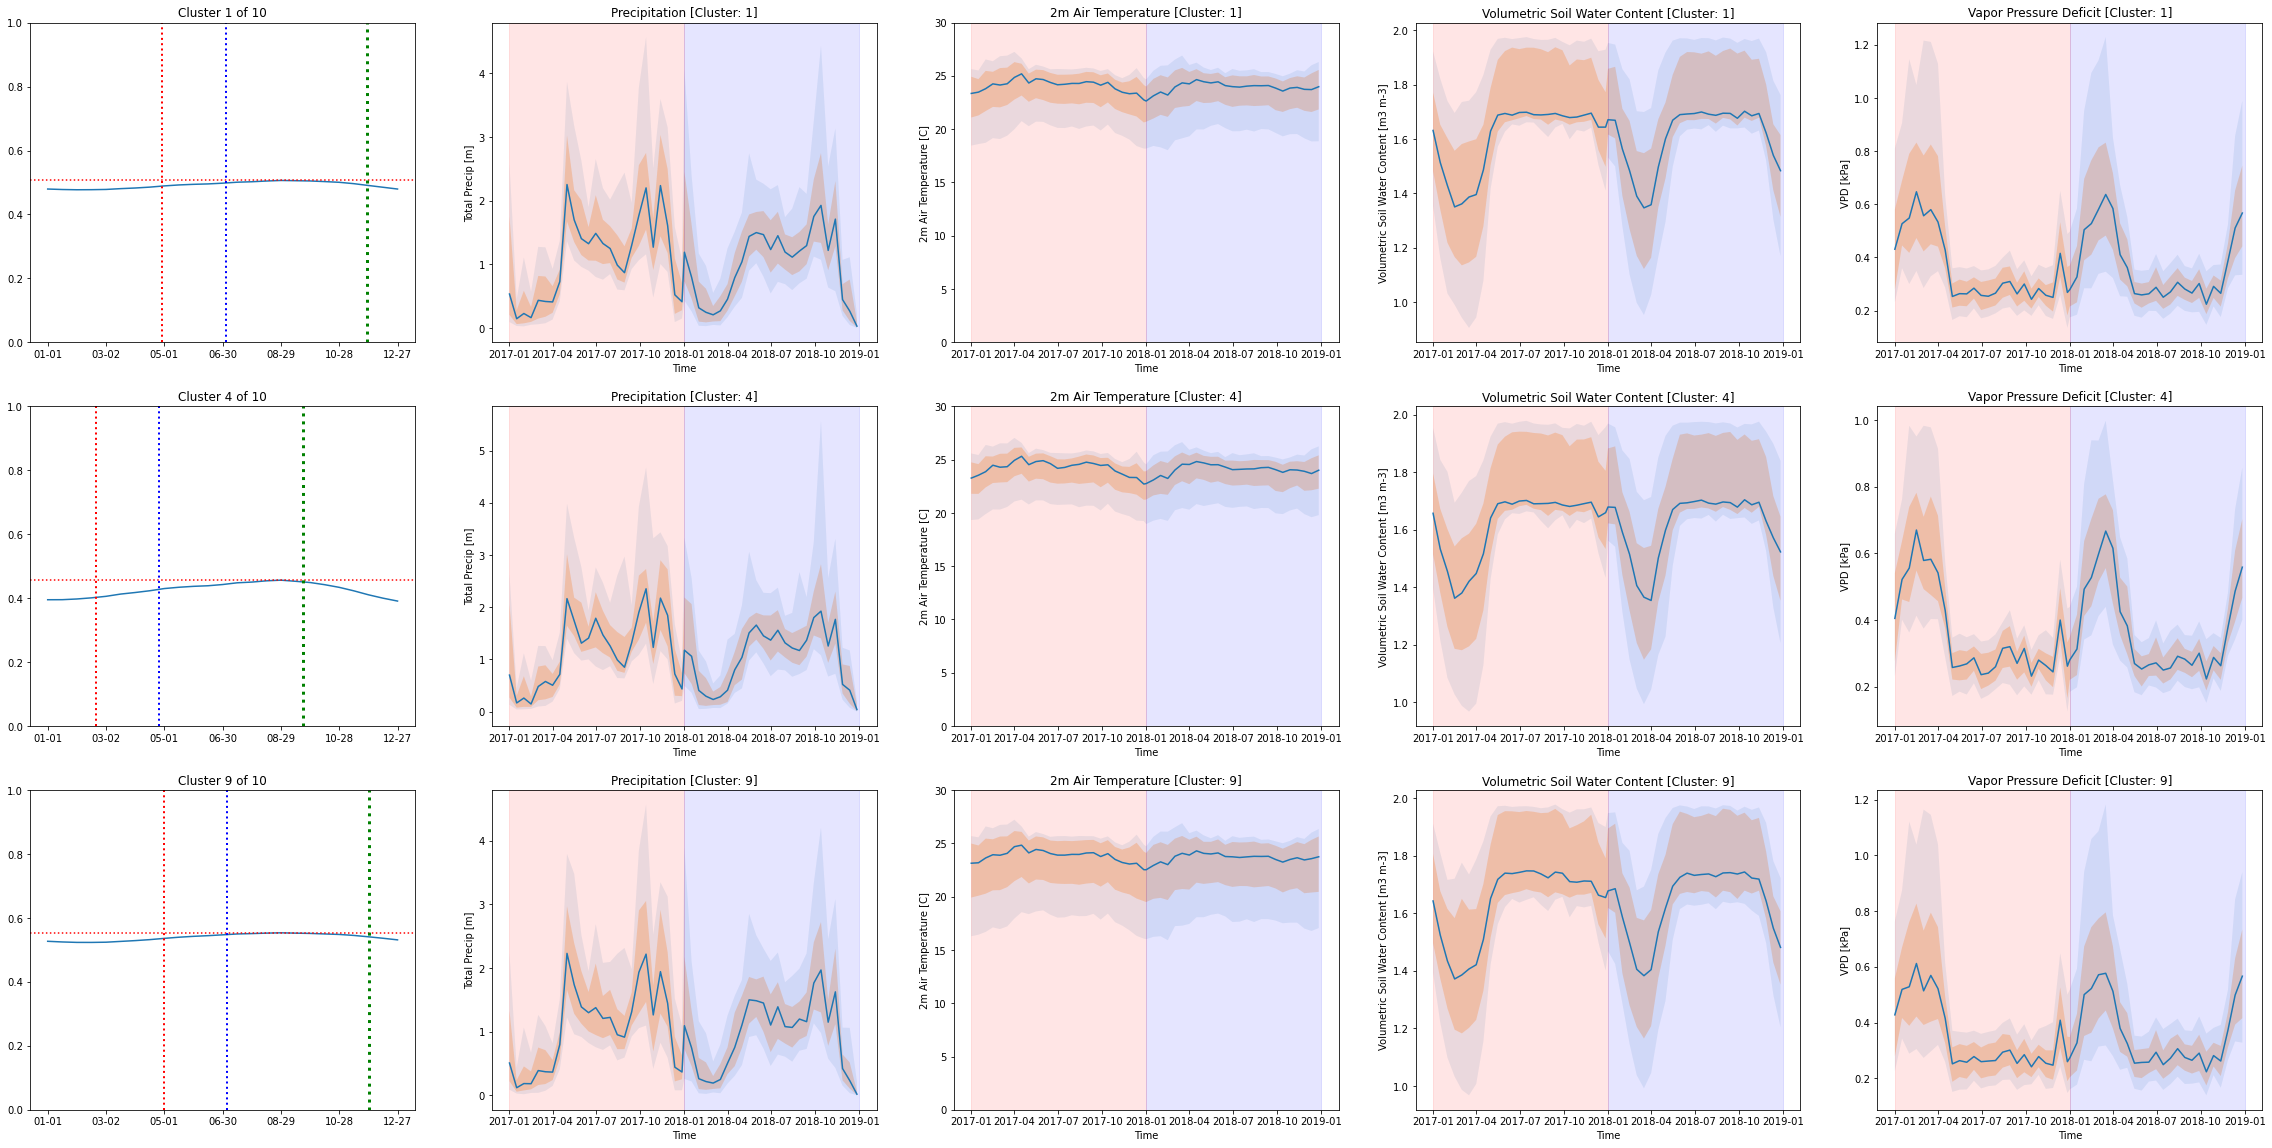

In [61]:
# Plot for each cluster

fig, axs = plt.subplots(3, 5, figsize=(40,20))
#######################################################################################################################
k=0
# Plot Cluster centroid
axs[0,0].plot(kdoys, k10_cent.iloc[k,:])
axs[0,0].axhline(k10_cent.iloc[k,:].max(), linestyle='dotted', color='red')
axs[0,0].set_ylim([0,1])
axs[0,0].set_xticks(np.arange(1,365,60))
axs[0,0].set_xticklabels(kdates[::4])
axs[0,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['ES'].iloc[0], linestyle='dotted', color='blue', linewidth='2')
axs[0,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['MS'].iloc[0], linestyle='dotted', color='green', linewidth='3')
axs[0,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['LS'].iloc[0], linestyle='dotted', color='red', linewidth='2')
axs[0,0].set_title('Cluster %d of %d'%(k+1, nclust))
    
# Plot Total Precipitation
axs[0,1].fill_between(k10_1_1_tp_stats[k10_1_1_tp_stats['zone']==(k+1)].index, k10_1_1_tp_stats[k10_1_1_tp_stats['zone']==(k+1)]['perc_10'], k10_1_1_tp_stats[k10_1_1_tp_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
axs[0,1].fill_between(k10_1_1_tp_stats[k10_1_1_tp_stats['zone']==(k+1)].index, k10_1_1_tp_stats[k10_1_1_tp_stats['zone']==(k+1)]['first_quart'], k10_1_1_tp_stats[k10_1_1_tp_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
axs[0,1].plot(k10_1_1_tp_stats[k10_1_1_tp_stats['zone']==(k+1)].index, k10_1_1_tp_stats[k10_1_1_tp_stats['zone']==(k+1)]['median'])
axs[0,1].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[0,1].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,1].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,1].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[0,1].set_title("Precipitation [Cluster: %d]"%(k+1))
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Total Precip [m]")
#   axs[k,1].set_xlim([phen_years[0], phen_years[1]])
#axs[k,1].set_ylim([0,6])
#ax2=axs[k,1].twinx()
#ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

    
# Plot 2m air temperature
axs[0,2].fill_between(k10_1_1_t2m_stats[k10_1_1_t2m_stats['zone']==(k+1)].index, k10_1_1_t2m_stats[k10_1_1_t2m_stats['zone']==(k+1)]['perc_10']-273.16, k10_1_1_t2m_stats[k10_1_1_t2m_stats['zone']==(k+1)]['perc_90']-273.16, alpha=0.10)
axs[0,2].fill_between(k10_1_1_t2m_stats[k10_1_1_t2m_stats['zone']==(k+1)].index, k10_1_1_t2m_stats[k10_1_1_t2m_stats['zone']==(k+1)]['first_quart']-273.16, k10_1_1_t2m_stats[k10_1_1_t2m_stats['zone']==(k+1)]['third_quart']-273.16, alpha=0.25)
axs[0,2].plot(k10_1_1_tp_stats[k10_1_1_tp_stats['zone']==(k+1)].index, k10_1_1_t2m_stats[k10_1_1_t2m_stats['zone']==(k+1)]['median']-273.16)
axs[0,2].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[0,2].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,2].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,2].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[0,2].set_title("2m Air Temperature [Cluster: %d]"%(k+1))
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("2m Air Temperature [C]")
#axs[k,2].set_xlim([phen_years[0], phen_years[1]])
axs[0,2].set_ylim([0,30])
#   ax2=axs[k,2].twinx()
#    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")
    
# Plot volumetric soil water content 
axs[0,3].fill_between(k10_1_1_swvl_stats[k10_1_1_swvl_stats['zone']==(k+1)].index, k10_1_1_swvl_stats[k10_1_1_swvl_stats['zone']==(k+1)]['perc_10'], k10_1_1_swvl_stats[k10_1_1_swvl_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
axs[0,3].fill_between(k10_1_1_swvl_stats[k10_1_1_swvl_stats['zone']==(k+1)].index, k10_1_1_swvl_stats[k10_1_1_swvl_stats['zone']==(k+1)]['first_quart'], k10_1_1_swvl_stats[k10_1_1_swvl_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
axs[0,3].plot(k10_1_1_swvl_stats[k10_1_1_swvl_stats['zone']==(k+1)].index, k10_1_1_swvl_stats[k10_1_1_swvl_stats['zone']==(k+1)]['median'])
axs[0,3].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[k,3].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,3].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,3].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[0,3].set_title("Volumetric Soil Water Content [Cluster: %d]"%(k+1))
axs[0,3].set_xlabel("Time")
axs[0,3].set_ylabel("Volumetric Soil Water Content [m3 m-3]")
 #   axs[k,3].set_xlim([phen_years[0], phen_years[1]])
#    axs[k,3].set_ylim([0,30])
#    ax2=axs[k,3].twinx()
#    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

    
# Plot VPD
axs[0,4].fill_between(k10_1_1_vpd_stats[k10_1_1_vpd_stats['zone']==(k+1)].index, k10_1_1_vpd_stats[k10_1_1_vpd_stats['zone']==(k+1)]['perc_10'], k10_1_1_vpd_stats[k10_1_1_vpd_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
axs[0,4].fill_between(k10_1_1_vpd_stats[k10_1_1_vpd_stats['zone']==(k+1)].index, k10_1_1_vpd_stats[k10_1_1_vpd_stats['zone']==(k+1)]['first_quart'], k10_1_1_vpd_stats[k10_1_1_vpd_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
axs[0,4].plot(k10_1_1_vpd_stats[k10_1_1_vpd_stats['zone']==(k+1)].index, k10_1_1_vpd_stats[k10_1_1_vpd_stats['zone']==(k+1)]['median'])
axs[0,4].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[0,4].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,4].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,4].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[0,4].set_title("Vapor Pressure Deficit [Cluster: %d]"%(k+1))
axs[0,4].set_xlabel("Time")
axs[0,4].set_ylabel("VPD [kPa]")
 #   axs[k,4].set_xlim([phen_years[0], phen_years[1]])
#    axs[k,4].set_ylim([0,2])
#    ax2=axs[k,4].twinx()
#    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

##############################################################################
#######################################################################################################################
k=3
# Plot Cluster centroid
axs[1,0].plot(kdoys, k10_cent.iloc[k,:])
axs[1,0].axhline(k10_cent.iloc[k,:].max(), linestyle='dotted', color='red')
axs[1,0].set_ylim([0,1])
axs[1,0].set_xticks(np.arange(1,365,60))
axs[1,0].set_xticklabels(kdates[::4])
axs[1,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['ES'].iloc[0], linestyle='dotted', color='blue', linewidth='2')
axs[1,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['MS'].iloc[0], linestyle='dotted', color='green', linewidth='3')
axs[1,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['LS'].iloc[0], linestyle='dotted', color='red', linewidth='2')
axs[1,0].set_title('Cluster %d of %d'%(k+1, nclust))
    
# Plot Total Precipitation
axs[1,1].fill_between(k10_1_4_tp_stats[k10_1_4_tp_stats['zone']==(k+1)].index, k10_1_4_tp_stats[k10_1_4_tp_stats['zone']==(k+1)]['perc_10'], k10_1_4_tp_stats[k10_1_4_tp_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
axs[1,1].fill_between(k10_1_4_tp_stats[k10_1_4_tp_stats['zone']==(k+1)].index, k10_1_4_tp_stats[k10_1_4_tp_stats['zone']==(k+1)]['first_quart'], k10_1_4_tp_stats[k10_1_4_tp_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
axs[1,1].plot(k10_1_4_tp_stats[k10_1_4_tp_stats['zone']==(k+1)].index, k10_1_4_tp_stats[k10_1_4_tp_stats['zone']==(k+1)]['median'])
axs[1,1].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[1,1].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,1].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,1].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[1,1].set_title("Precipitation [Cluster: %d]"%(k+1))
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Total Precip [m]")
#   axs[k,1].set_xlim([phen_years[0], phen_years[1]])
#axs[k,1].set_ylim([0,6])
#ax2=axs[k,1].twinx()
#ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

    
# Plot 2m air temperature
axs[1,2].fill_between(k10_1_4_t2m_stats[k10_1_4_t2m_stats['zone']==(k+1)].index, k10_1_4_t2m_stats[k10_1_4_t2m_stats['zone']==(k+1)]['perc_10']-273.16, k10_1_4_t2m_stats[k10_1_4_t2m_stats['zone']==(k+1)]['perc_90']-273.16, alpha=0.10)
axs[1,2].fill_between(k10_1_4_t2m_stats[k10_1_4_t2m_stats['zone']==(k+1)].index, k10_1_4_t2m_stats[k10_1_4_t2m_stats['zone']==(k+1)]['first_quart']-273.16, k10_1_4_t2m_stats[k10_1_4_t2m_stats['zone']==(k+1)]['third_quart']-273.16, alpha=0.25)
axs[1,2].plot(k10_1_4_tp_stats[k10_1_4_tp_stats['zone']==(k+1)].index, k10_1_4_t2m_stats[k10_1_4_t2m_stats['zone']==(k+1)]['median']-273.16)
axs[1,2].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[1,2].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,2].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,2].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[1,2].set_title("2m Air Temperature [Cluster: %d]"%(k+1))
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("2m Air Temperature [C]")
#axs[k,2].set_xlim([phen_years[0], phen_years[1]])
axs[1,2].set_ylim([0,30])
#   ax2=axs[k,2].twinx()
#    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")
    
# Plot volumetric soil water content 
axs[1,3].fill_between(k10_1_4_swvl_stats[k10_1_4_swvl_stats['zone']==(k+1)].index, k10_1_4_swvl_stats[k10_1_4_swvl_stats['zone']==(k+1)]['perc_10'], k10_1_4_swvl_stats[k10_1_4_swvl_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
axs[1,3].fill_between(k10_1_4_swvl_stats[k10_1_4_swvl_stats['zone']==(k+1)].index, k10_1_4_swvl_stats[k10_1_4_swvl_stats['zone']==(k+1)]['first_quart'], k10_1_4_swvl_stats[k10_1_4_swvl_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
axs[1,3].plot(k10_1_4_swvl_stats[k10_1_4_swvl_stats['zone']==(k+1)].index, k10_1_4_swvl_stats[k10_1_4_swvl_stats['zone']==(k+1)]['median'])
axs[1,3].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[1,3].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,3].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,3].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[1,3].set_title("Volumetric Soil Water Content [Cluster: %d]"%(k+1))
axs[1,3].set_xlabel("Time")
axs[1,3].set_ylabel("Volumetric Soil Water Content [m3 m-3]")
 #   axs[k,3].set_xlim([phen_years[0], phen_years[1]])
#    axs[k,3].set_ylim([0,30])
#    ax2=axs[k,3].twinx()
#    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

    
# Plot VPD
axs[1,4].fill_between(k10_1_4_vpd_stats[k10_1_4_vpd_stats['zone']==(k+1)].index, k10_1_4_vpd_stats[k10_1_4_vpd_stats['zone']==(k+1)]['perc_10'], k10_1_4_vpd_stats[k10_1_4_vpd_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
axs[1,4].fill_between(k10_1_4_vpd_stats[k10_1_4_vpd_stats['zone']==(k+1)].index, k10_1_4_vpd_stats[k10_1_4_vpd_stats['zone']==(k+1)]['first_quart'], k10_1_4_vpd_stats[k10_1_4_vpd_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
axs[1,4].plot(k10_1_4_vpd_stats[k10_1_4_vpd_stats['zone']==(k+1)].index, k10_1_4_vpd_stats[k10_1_4_vpd_stats['zone']==(k+1)]['median'])
axs[1,4].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[1,4].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,4].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,4].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[1,4].set_title("Vapor Pressure Deficit [Cluster: %d]"%(k+1))
axs[1,4].set_xlabel("Time")
axs[1,4].set_ylabel("VPD [kPa]")
 #   axs[k,4].set_xlim([phen_years[0], phen_years[1]])
#    axs[k,4].set_ylim([0,2])
#    ax2=axs[k,4].twinx()
#    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

##############################################################################
#######################################################################################################################
k=8
# Plot Cluster centroid
axs[2,0].plot(kdoys, k10_cent.iloc[k,:])
axs[2,0].axhline(k10_cent.iloc[k,:].max(), linestyle='dotted', color='red')
axs[2,0].set_ylim([0,1])
axs[2,0].set_xticks(np.arange(1,365,60))
axs[2,0].set_xticklabels(kdates[::4])
axs[2,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['ES'].iloc[0], linestyle='dotted', color='blue', linewidth='2')
axs[2,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['MS'].iloc[0], linestyle='dotted', color='green', linewidth='3')
axs[2,0].axvline(k10_polar[k10_polar['Cluster']==k+1]['LS'].iloc[0], linestyle='dotted', color='red', linewidth='2')
axs[2,0].set_title('Cluster %d of %d'%(k+1, nclust))
    
# Plot Total Precipitation
axs[2,1].fill_between(k10_1_9_tp_stats[k10_1_9_tp_stats['zone']==(k+1)].index, k10_1_9_tp_stats[k10_1_9_tp_stats['zone']==(k+1)]['perc_10'], k10_1_9_tp_stats[k10_1_9_tp_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
axs[2,1].fill_between(k10_1_9_tp_stats[k10_1_9_tp_stats['zone']==(k+1)].index, k10_1_9_tp_stats[k10_1_9_tp_stats['zone']==(k+1)]['first_quart'], k10_1_9_tp_stats[k10_1_9_tp_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
axs[2,1].plot(k10_1_9_tp_stats[k10_1_9_tp_stats['zone']==(k+1)].index, k10_1_9_tp_stats[k10_1_9_tp_stats['zone']==(k+1)]['median'])
axs[2,1].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[2,1].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,1].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,1].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[2,1].set_title("Precipitation [Cluster: %d]"%(k+1))
axs[2,1].set_xlabel("Time")
axs[2,1].set_ylabel("Total Precip [m]")
#   axs[k,1].set_xlim([phen_years[0], phen_years[1]])
#axs[k,1].set_ylim([0,6])
#ax2=axs[k,1].twinx()
#ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

    
# Plot 2m air temperature
axs[2,2].fill_between(k10_1_9_t2m_stats[k10_1_9_t2m_stats['zone']==(k+1)].index, k10_1_9_t2m_stats[k10_1_9_t2m_stats['zone']==(k+1)]['perc_10']-273.16, k10_1_9_t2m_stats[k10_1_9_t2m_stats['zone']==(k+1)]['perc_90']-273.16, alpha=0.10)
axs[2,2].fill_between(k10_1_9_t2m_stats[k10_1_9_t2m_stats['zone']==(k+1)].index, k10_1_9_t2m_stats[k10_1_9_t2m_stats['zone']==(k+1)]['first_quart']-273.16, k10_1_9_t2m_stats[k10_1_9_t2m_stats['zone']==(k+1)]['third_quart']-273.16, alpha=0.25)
axs[2,2].plot(k10_1_9_tp_stats[k10_1_9_tp_stats['zone']==(k+1)].index, k10_1_9_t2m_stats[k10_1_9_t2m_stats['zone']==(k+1)]['median']-273.16)
axs[2,2].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[2,2].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,2].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,2].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[2,2].set_title("2m Air Temperature [Cluster: %d]"%(k+1))
axs[2,2].set_xlabel("Time")
axs[2,2].set_ylabel("2m Air Temperature [C]")
#axs[k,2].set_xlim([phen_years[0], phen_years[1]])
axs[2,2].set_ylim([0,30])
#   ax2=axs[k,2].twinx()
#    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")
    
# Plot volumetric soil water content 
axs[2,3].fill_between(k10_1_9_swvl_stats[k10_1_9_swvl_stats['zone']==(k+1)].index, k10_1_9_swvl_stats[k10_1_9_swvl_stats['zone']==(k+1)]['perc_10'], k10_1_9_swvl_stats[k10_1_9_swvl_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
axs[2,3].fill_between(k10_1_9_swvl_stats[k10_1_9_swvl_stats['zone']==(k+1)].index, k10_1_9_swvl_stats[k10_1_9_swvl_stats['zone']==(k+1)]['first_quart'], k10_1_9_swvl_stats[k10_1_9_swvl_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
axs[2,3].plot(k10_1_9_swvl_stats[k10_1_9_swvl_stats['zone']==(k+1)].index, k10_1_9_swvl_stats[k10_1_9_swvl_stats['zone']==(k+1)]['median'])
axs[2,3].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[2,3].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,3].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,3].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[2,3].set_title("Volumetric Soil Water Content [Cluster: %d]"%(k+1))
axs[2,3].set_xlabel("Time")
axs[2,3].set_ylabel("Volumetric Soil Water Content [m3 m-3]")
 #   axs[k,3].set_xlim([phen_years[0], phen_years[1]])
#    axs[k,3].set_ylim([0,30])
#    ax2=axs[k,3].twinx()
#    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

    
# Plot VPD
axs[2,4].fill_between(k10_1_9_vpd_stats[k10_1_9_vpd_stats['zone']==(k+1)].index, k10_1_9_vpd_stats[k10_1_9_vpd_stats['zone']==(k+1)]['perc_10'], k10_1_9_vpd_stats[k10_1_9_vpd_stats['zone']==(k+1)]['perc_90'], alpha=0.10)
axs[2,4].fill_between(k10_1_9_vpd_stats[k10_1_9_vpd_stats['zone']==(k+1)].index, k10_1_9_vpd_stats[k10_1_9_vpd_stats['zone']==(k+1)]['first_quart'], k10_1_9_vpd_stats[k10_1_9_vpd_stats['zone']==(k+1)]['third_quart'], alpha=0.25)
axs[2,4].plot(k10_1_9_vpd_stats[k10_1_9_vpd_stats['zone']==(k+1)].index, k10_1_9_vpd_stats[k10_1_9_vpd_stats['zone']==(k+1)]['median'])
axs[2,4].axvspan(phen_years[0], phen_years[1], alpha=0.10, color='red')
axs[2,4].axvspan(phen_years[1], phen_years[2], alpha=0.10, color='blue')
#axs[k,4].axvspan(phen_years[2], phen_years[3], alpha=0.10, color='green')
#axs[k,4].axvspan(phen_years[3], phen_years[4], alpha=0.10, color='yellow')
axs[2,4].set_title("Vapor Pressure Deficit [Cluster: %d]"%(k+1))
axs[2,4].set_xlabel("Time")
axs[2,4].set_ylabel("VPD [kPa]")
 #   axs[k,4].set_xlim([phen_years[0], phen_years[1]])
#    axs[k,4].set_ylim([0,2])
#    ax2=axs[k,4].twinx()
#    ax2.scatter(adates, k10_area.iloc[k,1:]/1000000)
#    ax2.set_ylim([0,4])
#    ax2.set_ylabel("Area [Million Hectares]")

##############################################################################
plt.savefig('k10_1_example.png', dpi=300)

In [20]:
k10_1_1_t2m_stats

,zone,label,non_null_cells,null_cells,min,max,range,mean,mean_of_abs,stddev,variance,coeff_var,sum,sum_abs,first_quart,median,third_quart,perc_10,perc_90
date,,,,,,,,,,,,,,,,,,,
2017-01-01,1,NaN,37450163,882785,285.246674,300.011658,14.764984,295.816488,295.816488,2.886188,8.330084,0.975669,1.107838e+10,1.107838e+10,294.255,296.515,298.080,291.622,298.796
2017-01-16,1,NaN,37450163,882785,285.197388,300.087830,14.890442,295.832790,295.832790,2.811144,7.902529,0.950248,1.107899e+10,1.107899e+10,294.449,296.636,297.857,291.766,298.666
2017-01-31,1,NaN,37450163,882785,285.776398,301.363037,15.586639,296.343020,296.343020,3.011407,9.068570,1.016189,1.109809e+10,1.109809e+10,294.856,296.961,298.631,291.887,299.701
2017-02-15,1,NaN,37450163,882785,285.659882,301.312469,15.652588,296.582764,296.582764,2.887960,8.340314,0.973745,1.110707e+10,1.110707e+10,295.248,297.411,298.545,292.321,299.532
2017-03-02,1,NaN,37450163,882785,285.550903,301.983521,16.432617,296.693245,296.693245,3.049771,9.301103,1.027921,1.111121e+10,1.111121e+10,295.206,297.303,298.893,292.242,300.006
2017-03-17,1,NaN,37450163,882785,286.164246,301.796387,15.632141,296.838552,296.838552,2.931726,8.595016,0.987650,1.111665e+10,1.111665e+10,295.430,297.421,298.936,292.552,300.062
2017-04-01,1,NaN,37450163,882785,286.574768,302.627533,16.052765,297.372662,297.372662,2.904032,8.433401,0.976563,1.113665e+10,1.113665e+10,295.936,298.018,299.452,293.155,300.409
2017-04-16,1,NaN,37450163,882785,286.989899,301.625854,14.635956,297.483806,297.483806,2.587555,6.695442,0.869814,1.114082e+10,1.114082e+10,296.316,298.353,299.301,293.917,299.798
2017-05-01,1,NaN,37450163,882785,286.807434,300.280243,13.472809,296.704653,296.704653,2.347407,5.510320,0.791160,1.111164e+10,1.111164e+10,295.731,297.492,298.378,293.445,298.787


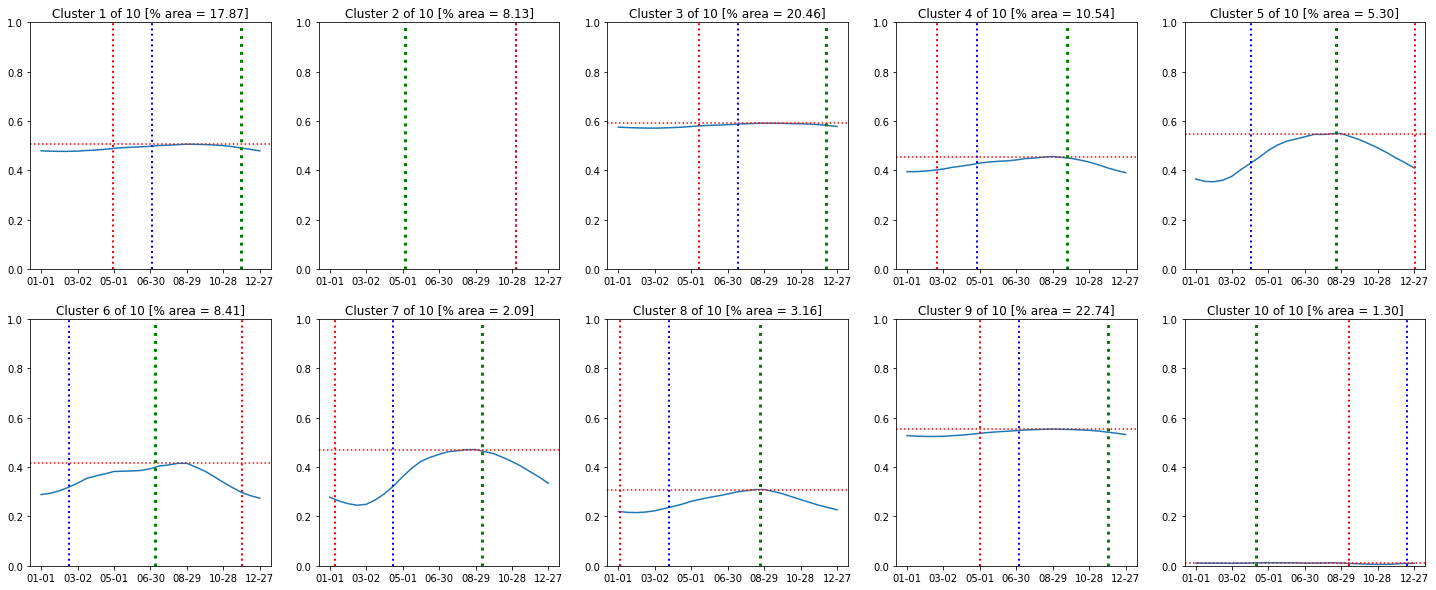

In [63]:
# Read k=10 final centroids
k10_cent = pd.read_csv('k_10/seeds.out.costa_rica_panama_biweekly_smooth.2017-2020.10.final', delimiter="\t", header=None)
#k10_cent = np.loadtxt('k_10/seeds.out.costa_rica_panama_biweekly_smooth.2017-2020.20.final', delimiter='\t')
clust=10
ncols=5
nrows=int(clust/5)
#kdates=["01-01", "01-16", "01-31", "02-15", "03-02", "03-17", "04-01", "04-16", "05-01", "05-16", "05-31", "06-15", "06-30", "07-15", "07-30", "08-14", "08-29", "09-13", "09-28", "10-13", "10-28", "11-12", "11-27", "12-12", "12-27"]
parea=[17.87, 8.13, 20.46, 10.54, 5.30, 8.41, 2.09, 3.16, 22.74, 1.30]
fig, ax = plt.subplots(nrows, ncols, figsize=(25,10))

for k in range(clust):
    r=int(k/ncols)
    c=int(k%ncols)
    ax[r,c].plot(kdoys, k10_cent.iloc[k,:])

    ax[r,c].set_ylim([0,1])
#    ax[r,c].set_xticks(np.arange(0,25,6))
    ax[r,c].set_xticks(np.arange(1,365,60))
    ax[r,c].axhline(k10_cent.iloc[k,:].max(), linestyle='dotted', color='red')
    ax[r,c].set_title('Cluster %d of %d [%% area = %0.2f]'%(k+1, clust, parea[k]))
    ax[r,c].set_xticklabels(kdates[::4])
    ax[r,c].axvline(k10_polar[k10_polar['Cluster']==k+1]['ES'].iloc[0], linestyle='dotted', color='blue', linewidth='2')
    ax[r,c].axvline(k10_polar[k10_polar['Cluster']==k+1]['MS'].iloc[0], linestyle='dotted', color='green', linewidth='3')
    ax[r,c].axvline(k10_polar[k10_polar['Cluster']==k+1]['LS'].iloc[0], linestyle='dotted', color='red', linewidth='2')
plt.savefig('k10_centroids.png', dpi=300)

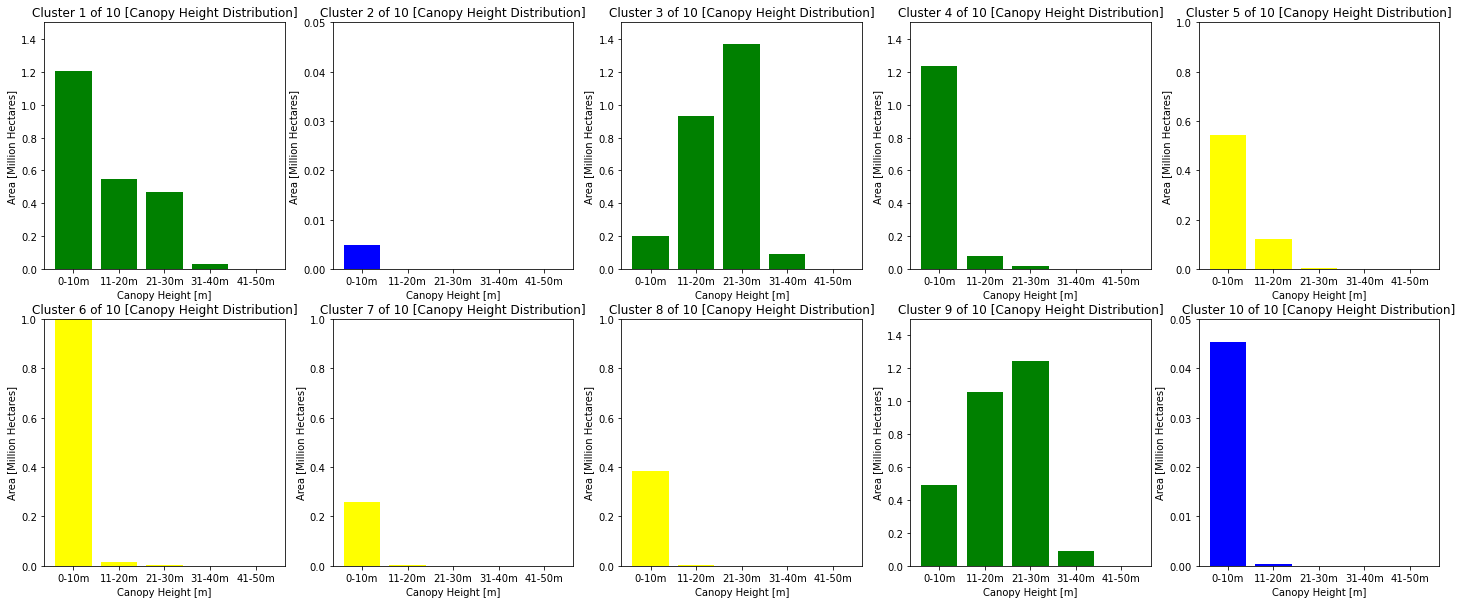

In [60]:
xlabels = ["0-10m", "11-20m", "21-30m", "31-40m", "41-50m"]
xtickval = [1,2,3,4,5]
k10_height = pd.read_csv('k_10/costa_rica_panama_k10_height.report.table', delimiter=" ", header=None)
fig, ax = plt.subplots(nrows, ncols, figsize=(25,10))

clr=['green', 'blue', 'green', 'green', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'blue']
xlim=[1.5, 0.05, 1.5, 1.5, 1, 1, 1, 1, 1.5, 0.05]

for k in range(clust):
    r=int(k/ncols)
    c=int(k%ncols)
    ax[r,c].bar(xtickval, k10_height.iloc[k+1,1:].astype(int)/1000000, color=clr[k])

    ax[r,c].set_ylim([0,xlim[k]])
    ax[r,c].set_xticks(xtickval)
    ax[r,c].set_xticklabels(xlabels)
    ax[r,c].set_ylabel("Area [Million Hectares]")
    ax[r,c].set_xlabel("Canopy Height [m]")
    ax[r,c].set_title('Cluster %d of %d [Canopy Height Distribution]'%(k+1, clust))
plt.savefig('k10_canopyheight.png', dpi=300)

In [41]:
k10_height.loc[1,1:].astype(int)/100

1    12059.29
2     5480.51
3     4702.50
4      349.57
5        0.36
Name: 1, dtype: float64